In [2]:
#!/Tsan/bin/python
# -*- coding: utf-8 -*-

In [3]:
# Libraries to use
from __future__ import division 
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import mysql.connector 
import json
import collections

c:\python27\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
import talib

In [5]:
# Import My own library for factor testing
from SingleFactorTest import factorFilterFunctions as ff
#from config import *

In [6]:
%matplotlib inline
%load_ext line_profiler

In [6]:
# {'600036':u'招商银行','002142':u'宁波银行','601939':u'建设银行','000709':u'河钢股份','000807':u'云铝股份','600111':u'北方稀土',
#  '002001':u'新和成','002562':u'兄弟科技','0300121':u'阳谷华泰','600352':u'浙江龙盛','600409':u'三友化工','000636':u'风华高科',
#  '000962':u'东方钽业','300228':u'富瑞特装'，'600681':u'百川能源','600789':u'鲁抗医药','002166':u'莱茵生物','002166':u'万华化学',
# '000933':u'神火股份','600977':u'中国电影','000802':u'北京文化','600809':u'山西汾酒','600438':u'通威股份','000970':u'中科三环'}

In [7]:
# 股票推荐字典
stkdict = {'20170815':['600036','002142','601939'], '20170814':['000709','000807','600111','002001','002562'],\
          '20170810':['300121','600352','600409'], '20170809':['000636','000962'], '20170808':['600803','300228','600681'],
          '20170807':['600789','002166','600309'],'20170803':['000933','600977','000802','600809'],
          '20170801':['600438'], '20170731':['600438','600111','000970']}

In [8]:
sortedstkdict = collections.OrderedDict(sorted(stkdict.items()))

In [8]:
fileNameClose = 'LZ_CN_STKA_QUOTE_TCLOSE.h5.csv'
fileNameOpen = 'LZ_CN_STKA_QUOTE_TOPEN.h5.csv'

In [7]:
path = ff.data_path
# Constants
startTime =  datetime.strptime('20170731', '%Y%m%d')
endTime = datetime.strptime('20170816', '%Y%m%d')

In [11]:
# 开盘价
openPrice= pd.read_csv(path+fileNameOpen,infer_datetime_format=True,parse_dates=[0],index_col=0).loc[startTime:endTime]

stkList = map(lambda x: x.split('.')[0],openPrice.columns[1:])

openPrice = openPrice.iloc[:,:-1]

openPrice.columns = stkList 

In [12]:
# 收盘价
closePrice= pd.read_csv(path+fileNameClose,infer_datetime_format=True,parse_dates=[0],index_col=0).loc[startTime:endTime]

stkList = map(lambda x: x.split('.')[0],closePrice.columns[1:])

closePrice = closePrice.iloc[:,:-1]

closePrice.columns = stkList

In [13]:
closePrice

,000005,600601,600602,600651,600652,600653,600654,600656,000004,000002,...,603535,300689,603458,300688,603602,300691,603721,601326,002892,603776
2017-07-31,4.94,3.87,7.16,9.12,9.86,3.26,13.48,NaN,22.31,23.37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,4.96,3.86,7.22,8.95,10.03,3.26,13.48,NaN,22.36,23.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-02,4.93,3.84,7.00,8.87,10.27,3.26,13.48,NaN,21.85,23.58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-03,4.94,3.83,7.70,9.04,10.21,3.26,13.48,NaN,22.22,23.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-04,4.9,3.84,7.72,8.93,9.76,3.26,13.48,NaN,21.88,22.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-07,4.89,3.85,7.62,8.95,9.82,3.26,13.48,NaN,22.00,22.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-08,4.88,3.86,7.59,8.88,9.78,3.26,13.48,NaN,21.91,22.77,...,21.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-09,4.88,3.86,7.57,8.89,9.75,3.26,13.48,NaN,22.17,22.95,...,24.02,20.72,42.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-10,4.83,3.80,7.87,8.69,9.58,3.26,13.48,NaN,21.80,22.80,...,26.42,22.79,46.51,15.48,21.86,NaN,NaN,NaN,NaN,NaN
2017-08-11,4.76,3.71,7.92,8.55,9.55,3.26,13.48,NaN,22.01,22.02,...,29.06,25.07,50.60,17.03,24.05,22.98,10.15,NaN,NaN,NaN


In [14]:
InitiCap = 100000  # 初始资金
capital = InitiCap  
feeRate = 0.0003  # 手续费+冲击成本
stampTaxRate = 0.001  # 印花税
buyList = []
availableCash = {}  # 每天的现金流量
# 生成购买的股票池
for key,item in sortedstkdict.iteritems():
    print key
    date = datetime.strptime(key, '%Y%m%d')
    totalCostToday = 0  # 当天买入的所有股票的成本
    for stk in item:        
        buyPrice = round(openPrice.loc[date][stk],2)
        amount = 100
        cost = round(buyPrice*amount*(1+feeRate),2)
        buyList.append([date,stk,buyPrice,amount,cost,1]) # 日期，股票代码，购买价格，购买数量，总cost,方向
        totalCostToday+= cost
    assert capital > totalCostToday
    capital  = capital  - totalCostToday
    availableCash[date] = capital  # 买入股票后剩下的资金

20170731
20170801
20170803
20170807
20170808
20170809
20170810
20170814
20170815


In [15]:
availableCash

{datetime.datetime(2017, 7, 31, 0, 0): 95882.77,
 datetime.datetime(2017, 8, 1, 0, 0): 95158.55,
 datetime.datetime(2017, 8, 3, 0, 0): 86145.85,
 datetime.datetime(2017, 8, 7, 0, 0): 80668.20000000001,
 datetime.datetime(2017, 8, 8, 0, 0): 76512.95000000001,
 datetime.datetime(2017, 8, 9, 0, 0): 74508.35,
 datetime.datetime(2017, 8, 10, 0, 0): 70507.15000000001,
 datetime.datetime(2017, 8, 14, 0, 0): 63355.00000000001,
 datetime.datetime(2017, 8, 15, 0, 0): 58697.61000000001}

In [16]:
dateList = sorted([datetime.strptime(key, '%Y%m%d') for key in stkdict.keys()])

dateList = closePrice.loc[dateList[0]:dateList[-1]].index

dateList

DatetimeIndex(['2017-07-31', '2017-08-01', '2017-08-02', '2017-08-03',
               '2017-08-04', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', freq=None)

In [17]:
availableCash

{datetime.datetime(2017, 7, 31, 0, 0): 95882.77,
 datetime.datetime(2017, 8, 1, 0, 0): 95158.55,
 datetime.datetime(2017, 8, 3, 0, 0): 86145.85,
 datetime.datetime(2017, 8, 7, 0, 0): 80668.20000000001,
 datetime.datetime(2017, 8, 8, 0, 0): 76512.95000000001,
 datetime.datetime(2017, 8, 9, 0, 0): 74508.35,
 datetime.datetime(2017, 8, 10, 0, 0): 70507.15000000001,
 datetime.datetime(2017, 8, 14, 0, 0): 63355.00000000001,
 datetime.datetime(2017, 8, 15, 0, 0): 58697.61000000001}

In [18]:
availableCashSeries = pd.Series(index = dateList,data = availableCash )

availableCashSeries = availableCashSeries.ffill()

availableCashSeries

2017-07-31    95882.77
2017-08-01    95158.55
2017-08-02    95158.55
2017-08-03    86145.85
2017-08-04    86145.85
2017-08-07    80668.20
2017-08-08    76512.95
2017-08-09    74508.35
2017-08-10    70507.15
2017-08-11    70507.15
2017-08-14    63355.00
2017-08-15    58697.61
dtype: float64

In [19]:
availableCashSeries

2017-07-31    95882.77
2017-08-01    95158.55
2017-08-02    95158.55
2017-08-03    86145.85
2017-08-04    86145.85
2017-08-07    80668.20
2017-08-08    76512.95
2017-08-09    74508.35
2017-08-10    70507.15
2017-08-11    70507.15
2017-08-14    63355.00
2017-08-15    58697.61
dtype: float64

In [20]:
buyList

[[datetime.datetime(2017, 7, 31, 0, 0), '600438', 6.5, 100, 650.19, 1],
 [datetime.datetime(2017, 7, 31, 0, 0), '600111', 17.1, 100, 1710.51, 1],
 [datetime.datetime(2017, 7, 31, 0, 0), '000970', 17.56, 100, 1756.53, 1],
 [datetime.datetime(2017, 8, 1, 0, 0), '600438', 7.24, 100, 724.22, 1],
 [datetime.datetime(2017, 8, 3, 0, 0), '000933', 11.71, 100, 1171.35, 1],
 [datetime.datetime(2017, 8, 3, 0, 0), '600977', 18.08, 100, 1808.54, 1],
 [datetime.datetime(2017, 8, 3, 0, 0), '000802', 19.07, 100, 1907.57, 1],
 [datetime.datetime(2017, 8, 3, 0, 0), '600809', 41.24, 100, 4125.24, 1],
 [datetime.datetime(2017, 8, 7, 0, 0), '600789', 8.95, 100, 895.27, 1],
 [datetime.datetime(2017, 8, 7, 0, 0), '002166', 11.5, 100, 1150.35, 1],
 [datetime.datetime(2017, 8, 7, 0, 0), '600309', 34.31, 100, 3432.03, 1],
 [datetime.datetime(2017, 8, 8, 0, 0), '600803', 13.91, 100, 1391.42, 1],
 [datetime.datetime(2017, 8, 8, 0, 0), '300228', 11.18, 100, 1118.34, 1],
 [datetime.datetime(2017, 8, 8, 0, 0), '6006

In [21]:
# 简单回测
cutwinthreshold = 0.05
cutlossthreshold  = -0.05
pnldict = {}
sellList = []
for tradeitem in buyList:
    pnl = (closePrice.loc[tradeitem[0]:][tradeitem[1]] - tradeitem[2]) / tradeitem[2]  # 计算每天的pnl
    cutwin = pnl[pnl >= cutwinthreshold]
    cutloss = pnl[pnl <= cutlossthreshold]
    if len(cutwin) > 0:    # 如果达到止盈线，则按当天收盘价止盈
        pnldict[tradeitem[1]] = round(cutwin .iloc[0],2)
        selldate = cutwin.index[0]
        sellPrice = closePrice.loc[selldate][tradeitem[1]]
        cost = round(sellPrice*tradeitem[3]*(1-stampTaxRate),2)
        sellList.append([selldate,tradeitem[1],round(sellPrice,2),tradeitem[3],cost,-1]) # 卖出list的格式与买入相同
        availableCashSeries.loc[selldate:]+= cost   # 记录到资金账户里
    elif  len(cutloss) > 0:     #  反之则止损
        pnldict[tradeitem[1]] = round(cutloss .iloc[0],2)
        selldate = cutloss.index[0]
        sellPrice = closePrice.loc[selldate][tradeitem[1]]
        cost = round(sellPrice*tradeitem[3]*(1-stampTaxRate),2)
        sellList.append([selldate,tradeitem[1],round(sellPrice,2),tradeitem[3],cost,-1]) # 卖出list的格式与买入相同
        availableCashSeries.loc[selldate:]+= cost 
    else:                                   # 没有达到止盈止损线的情况下，按照倒数第二天的收盘价计算pnl
        pnldict[tradeitem[1]] = round(pnl.iloc[-2],2)

In [22]:
sellList

[[Timestamp('2017-07-31 00:00:00'), '600438', 7.11, 100, 710.29, -1],
 [Timestamp('2017-07-31 00:00:00'), '600111', 18.61, 100, 1859.14, -1],
 [Timestamp('2017-08-09 00:00:00'), '000970', 18.78, 100, 1876.12, -1],
 [Timestamp('2017-08-04 00:00:00'), '000933', 12.35, 100, 1233.77, -1],
 [Timestamp('2017-08-04 00:00:00'), '000802', 20.74, 100, 2071.93, -1],
 [Timestamp('2017-08-07 00:00:00'), '600809', 43.99, 100, 4394.6, -1],
 [Timestamp('2017-08-09 00:00:00'), '600789', 9.43, 100, 942.06, -1],
 [Timestamp('2017-08-08 00:00:00'), '002166', 12.11, 100, 1209.79, -1],
 [Timestamp('2017-08-11 00:00:00'), '600309', 31.44, 100, 3140.86, -1],
 [Timestamp('2017-08-14 00:00:00'), '600803', 14.84, 100, 1482.52, -1],
 [Timestamp('2017-08-10 00:00:00'), '000636', 9.51, 100, 950.05, -1],
 [Timestamp('2017-08-14 00:00:00'), '000962', 10.54, 100, 1052.95, -1],
 [Timestamp('2017-08-11 00:00:00'), '300121', 14.75, 100, 1473.53, -1],
 [Timestamp('2017-08-11 00:00:00'), '600352', 10.51, 100, 1049.95, -1],

In [23]:
holdingList = list(set([i[1] for i in buyList]) - set([i[1] for i in sellList]))

In [24]:
holdingList

['000807',
 '600681',
 '600036',
 '000709',
 '002001',
 '600977',
 '002142',
 '601939',
 '300228']

In [25]:
selldatepair = {i[1]:i[0] for i in buyList if i[1] in holdingList}
selldatepair

{'000709': datetime.datetime(2017, 8, 14, 0, 0),
 '000807': datetime.datetime(2017, 8, 14, 0, 0),
 '002001': datetime.datetime(2017, 8, 14, 0, 0),
 '002142': datetime.datetime(2017, 8, 15, 0, 0),
 '300228': datetime.datetime(2017, 8, 8, 0, 0),
 '600036': datetime.datetime(2017, 8, 15, 0, 0),
 '600681': datetime.datetime(2017, 8, 8, 0, 0),
 '600977': datetime.datetime(2017, 8, 3, 0, 0),
 '601939': datetime.datetime(2017, 8, 15, 0, 0)}

In [26]:
tempo = closePrice[holdingList]

In [27]:
position = tempo.copy()
for stk,date in selldatepair.iteritems():
    filterCondition = tempo[tempo[stk].index >= date]
    falseCondition= tempo[tempo[stk].index  < date]
    position.loc[filterCondition.index,stk]= 100
    position.loc[falseCondition.index,stk]=  0
position

,000807,600681,600036,000709,002001,600977,002142,601939,300228
2017-07-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-03,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
2017-08-04,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
2017-08-07,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
2017-08-08,0.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,100.0
2017-08-09,0.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,100.0
2017-08-10,0.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,100.0
2017-08-11,0.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,100.0


In [28]:
marketValue = position*tempo

In [29]:
marketValue.sum(axis=1)+availableCashSeries

2017-07-31     98452.20
2017-08-01     97727.98
2017-08-02     97727.98
2017-08-03     90568.28
2017-08-04     93836.98
2017-08-07     92755.93
2017-08-08     92554.47
2017-08-09     93353.05
2017-08-10     90225.90
2017-08-11     97028.05
2017-08-14     98265.37
2017-08-15    100142.28
2017-08-16          NaN
dtype: float64

In [30]:
# 计算卖出时得到的资金
for sellitem in sellList:
    availableCashSeries.loc[sellitem[0]]+= sellitem[-2]
availableCashSeries

2017-07-31    101021.63
2017-08-01     97727.98
2017-08-02     97727.98
2017-08-03     88715.28
2017-08-04     95326.68
2017-08-07     95332.53
2017-08-08     89202.26
2017-08-09     91624.23
2017-08-10     86704.95
2017-08-11     99459.20
2017-08-14     94521.84
2017-08-15     88723.58
dtype: float64

In [31]:
# 合并买卖订单
tradingList = buyList + sellList
tradingCode = list(set([i[1] for i in buyList]) | set([i[1] for i in sellList]))

In [32]:
tradingList

[[datetime.datetime(2017, 7, 31, 0, 0), '600438', 6.5, 100, 650.19, 1],
 [datetime.datetime(2017, 7, 31, 0, 0), '600111', 17.1, 100, 1710.51, 1],
 [datetime.datetime(2017, 7, 31, 0, 0), '000970', 17.56, 100, 1756.53, 1],
 [datetime.datetime(2017, 8, 1, 0, 0), '600438', 7.24, 100, 724.22, 1],
 [datetime.datetime(2017, 8, 3, 0, 0), '000933', 11.71, 100, 1171.35, 1],
 [datetime.datetime(2017, 8, 3, 0, 0), '600977', 18.08, 100, 1808.54, 1],
 [datetime.datetime(2017, 8, 3, 0, 0), '000802', 19.07, 100, 1907.57, 1],
 [datetime.datetime(2017, 8, 3, 0, 0), '600809', 41.24, 100, 4125.24, 1],
 [datetime.datetime(2017, 8, 7, 0, 0), '600789', 8.95, 100, 895.27, 1],
 [datetime.datetime(2017, 8, 7, 0, 0), '002166', 11.5, 100, 1150.35, 1],
 [datetime.datetime(2017, 8, 7, 0, 0), '600309', 34.31, 100, 3432.03, 1],
 [datetime.datetime(2017, 8, 8, 0, 0), '600803', 13.91, 100, 1391.42, 1],
 [datetime.datetime(2017, 8, 8, 0, 0), '300228', 11.18, 100, 1118.34, 1],
 [datetime.datetime(2017, 8, 8, 0, 0), '6006

In [33]:
# 创建tradingsheet
tradingSheet = pd.DataFrame(index = dateList, columns = tradingCode, data=0, dtype = float)

for item in tradingList:
    tradingSheet .loc[item[0],item[1]]+= item[-1] * item[-3]
positionchangeDF = tradingSheet .cumsum().ffill()

In [34]:
tradingSheet 

,600309,000807,600681,000802,000933,600036,000709,002001,600977,600809,...,300121,000970,000636,600352,002562,600409,600789,600803,600438,600111
2017-07-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0
2017-08-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-03,0.0,0.0,0.0,100.0,100.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-04,0.0,0.0,0.0,-100.0,-100.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-07,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
2017-08-08,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
2017-08-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-100.0,100.0,0.0,0.0,0.0,-100.0,0.0,0.0,0.0
2017-08-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100.0,0.0,-100.0,100.0,0.0,100.0,0.0,0.0,0.0,0.0
2017-08-11,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-100.0,0.0,0.0,-100.0,0.0,-100.0,0.0,0.0,0.0,0.0


In [35]:
positionchangeDF

,600309,000807,600681,000802,000933,600036,000709,002001,600977,600809,...,300121,000970,000636,600352,002562,600409,600789,600803,600438,600111
2017-07-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0
2017-08-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0
2017-08-03,0.0,0.0,0.0,100.0,100.0,0.0,0.0,0.0,100.0,100.0,...,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0
2017-08-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0
2017-08-07,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,...,0.0,100.0,0.0,0.0,0.0,0.0,100.0,0.0,100.0,0.0
2017-08-08,100.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,...,0.0,100.0,0.0,0.0,0.0,0.0,100.0,100.0,100.0,0.0
2017-08-09,100.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,...,0.0,0.0,100.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0
2017-08-10,100.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,...,100.0,0.0,0.0,100.0,0.0,100.0,0.0,100.0,100.0,0.0
2017-08-11,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0


In [36]:
# 总资产
totalCapital= (positionchangeDF * closePrice[positionchangeDF.columns]).sum(axis=1)+ availableCashSeries

In [37]:
totalCapital

2017-07-31    102851.63
2017-08-01    100220.98
2017-08-02    100169.98
2017-08-03    100238.28
2017-08-04    103575.68
2017-08-07    105161.53
2017-08-08    102026.26
2017-08-09    103794.23
2017-08-10    101743.95
2017-08-11    107070.20
2017-08-14    105125.84
2017-08-15    102556.58
2017-08-16          NaN
dtype: float64

In [38]:
# 年化收益率
annualizedRet = ((totalCapital.iloc[-2] - InitiCap)/ InitiCap +1)**(250/(len(totalCapital)-1)) -1

In [39]:
annualizedRet 

0.69202537164493205

In [40]:
availableCashSeries

2017-07-31    101021.63
2017-08-01     97727.98
2017-08-02     97727.98
2017-08-03     88715.28
2017-08-04     95326.68
2017-08-07     95332.53
2017-08-08     89202.26
2017-08-09     91624.23
2017-08-10     86704.95
2017-08-11     99459.20
2017-08-14     94521.84
2017-08-15     88723.58
dtype: float64

In [41]:
pnlseries = pd.Series(pnldict)

In [42]:
pnlseries.describe()

count    25.000000
mean      0.018400
std       0.053126
min      -0.080000
25%      -0.010000
50%       0.030000
75%       0.060000
max       0.090000
dtype: float64

(array([ 3.,  2.,  0.,  0.,  4.,  2.,  3.,  4.,  5.,  2.]),
 array([-0.08 , -0.063, -0.046, -0.029, -0.012,  0.005,  0.022,  0.039,
         0.056,  0.073,  0.09 ]),
 <a list of 10 Patch objects>)

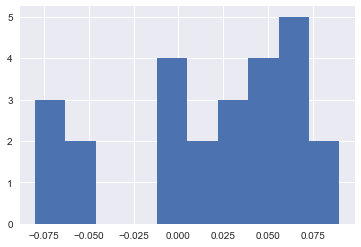

In [43]:
plt.hist(pnlseries)

In [1]:
#-----------------------------------------------------Market Timing------------------------------------

In [15]:
filenameHS300Member = 'LZ_CN_STKA_INDEX_HS300MEMBER.h5'
filenameCSI500Member = 'LZ_CN_STKA_INDEX_CSI500MEMBER.h5'

# 复权后价格
filenameAdjClose = 'OwnfactorAdjustedClose.h5'

In [21]:
teststartTime =  datetime.strptime('20120731', '%Y%m%d')
testendTime = datetime.strptime('20171016', '%Y%m%d')

In [10]:
def getMemberList(path,filename):
    df = ff.readh5data(path,filename).iloc[-1]
    return df.loc[df==1].index.tolist()

In [11]:
hs300MemberList = getMemberList(path, filenameHS300Member)
csi500MemberList = getMemberList(path, filenameCSI500Member)

In [29]:
priceData =  ff.readh5data(path,filenameAdjClose).pct_change().dropna(how='all').loc[teststartTime:testendTime]

In [49]:
priceData[hs300MemberList].loc[datetime.strptime('20170810', '%Y%m%d')].name

Timestamp('2017-08-10 00:00:00')

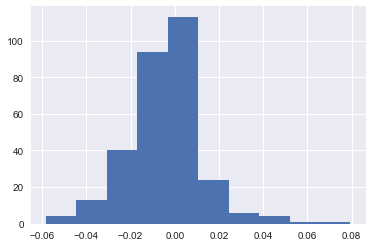

In [54]:
priceData[hs300MemberList].loc[datetime.strptime('20170810', '%Y%m%d')].hist()

In [40]:
priceData[csi500MemberList].iloc[-2].name

Timestamp('2017-10-12 00:00:00')

In [44]:
#-----------------------------------------------------CTA Backtest Engine------------------------------------

In [45]:
def getNewMatrix(inputArray, t, m):
    newMatrix = []
    n = t-m+1
    for i in range(n):
        newdata = list(inputArray[i:m+i])
        newMatrix.append(newdata)
    #newMatrix = np.array(newMatrix).reshape(n,m)
    return np.array(newMatrix)

def recreateArray(newMatrix,t,m):
    ret = []
    n = t - m + 1
    for p in range(1, t+1):
        if p < m:
            alpha = p
        elif p > t-m+1:
            alpha = t-p+1
        else:
            alpha = m
        sigma = 0
        for j in range(1, m+1):
            i = p - j + 1
            if i > 0 and i < n+1:
                sigma += newMatrix[i-1][j-1]
        ret.append(sigma/alpha)
    return np.array(ret)

def getSVD(inputArray,t,m):
    #print 1
    inputmatrix = getNewMatrix(inputArray, t, m)
    u, s, v = np.linalg.svd(inputmatrix)
    eviNum = 1 if s[0]/s.sum() > 0.99 else 2
    sNew = np.zeros((eviNum, eviNum))
    np.fill_diagonal(sNew, s[:eviNum])
    matrixForts = np.dot(np.dot(u[:, :eviNum].reshape(u.shape[0], eviNum), sNew), v[:eviNum])
    #print matrixForts.shape
    newts = recreateArray(matrixForts, t, m)
    return newts

In [46]:
old_path = 'C:/Users/LZJF_02/Desktop/original_data/'
new_path = 'C:/Users/LZJF_02/Desktop/modified_data/'
filename = 'rb000_1min.csv'
#newname = 'j9000_1min_modi.csv'

In [47]:
startTime =  datetime.strptime('20161010', '%Y%m%d') # 上涨趋势
endTime = datetime.strptime('20161107', '%Y%m%d')

startTrainTime = datetime.strptime('20150530', '%Y%m%d') 
endTimeTrain =  datetime.strptime('20160530', '%Y%m%d')

startTimeVal = datetime.strptime('20151016', '%Y%m%d')  # 下跌趋势
endTimeVal = datetime.strptime('20151123', '%Y%m%d')

startTimeSurge =  datetime.strptime('20170606', '%Y%m%d') # 上涨趋势
endTimeSurge = datetime.strptime('20170809', '%Y%m%d')

startTimePlunge =  datetime.strptime('20170906', '%Y%m%d') # 下跌趋势
endTimePlunge = datetime.strptime('20170929', '%Y%m%d')

In [48]:
# svd滤波参数
shapeNum = 30
svdShort = 7
svdLong = 20

In [49]:
# 期货合约相关参数
Leverage = 10
Slipage = 2
ContractSize = 10
IniCapital = 100000
FeeRate = 0.003
PriceTick = 1

In [50]:
data = pd.read_csv(old_path+filename,infer_datetime_format=True,header=None,names = ['Open', 'High', 'Low', 'Close','TotalVolume','OpenInterest'])
data.index = data.index.map(lambda x : pd.to_datetime(x))

In [51]:
data['OpenRatio'] = (data['OpenInterest'] - data['OpenInterest'].shift(1)) / data['TotalVolume']

In [52]:
data.loc[startTime:].describe()
data.loc[startTime:].quantile(0.85)

Open            3.646000e+03
High            3.648000e+03
Low             3.644000e+03
Close           3.646000e+03
TotalVolume     2.877000e+04
OpenInterest    4.941676e+06
OpenRatio       1.816483e-01
Name: 0.85, dtype: float64

In [53]:
data.tail(20)

,Open,High,Low,Close,TotalVolume,OpenInterest,OpenRatio
2017-09-18 11:16:00,3786,3789,3770,3776,56594,4057618,0.105559
2017-09-18 11:17:00,3775,3779,3771,3771,25718,4061640,0.156389
2017-09-18 11:18:00,3771,3780,3771,3776,15230,4065086,0.226264
2017-09-18 11:19:00,3776,3777,3772,3773,9056,4066862,0.196113
2017-09-18 11:20:00,3773,3773,3764,3766,38662,4072204,0.138172
2017-09-18 11:21:00,3767,3770,3766,3768,15876,4075438,0.203704
2017-09-18 11:22:00,3767,3768,3764,3764,18014,4077740,0.127789
2017-09-18 11:23:00,3763,3765,3759,3763,32302,4083090,0.165624
2017-09-18 11:24:00,3762,3768,3760,3768,15844,4085922,0.178743
2017-09-18 11:25:00,3769,3769,3762,3762,12436,4087190,0.101962


In [54]:
data.describe()

,Open,High,Low,Close,TotalVolume,OpenInterest,OpenRatio
count,576590.000000,576590.000000,576590.000000,576590.000000,576590.000000,5.765900e+05,576589.000000
mean,3279.472292,3280.876907,3278.048208,3279.472297,11638.035467,2.440778e+06,-0.003634
std,949.560688,949.722005,949.397871,949.559562,15181.314867,1.293012e+06,0.224045
min,1617.000000,1618.000000,1616.000000,1617.000000,2.000000,8.376000e+03,-1.638679
25%,2422.000000,2423.000000,2421.000000,2422.000000,2578.000000,1.345436e+06,-0.130831
50%,3409.000000,3410.000000,3407.000000,3409.000000,6876.000000,2.478721e+06,0.004251
75%,4074.000000,4076.000000,4072.000000,4074.000000,14788.000000,3.501908e+06,0.133173
max,5186.000000,5187.000000,5182.000000,5185.000000,583962.000000,6.040226e+06,1.000000


In [55]:
# 默认空值
EMPTY_STRING = ''
EMPTY_UNICODE = u''
EMPTY_INT = 0
EMPTY_FLOAT = 0.0
class BarData(object):
    def __init__(self):
        self.open = EMPTY_FLOAT             # OHLC
        self.high = EMPTY_FLOAT
        self.low = EMPTY_FLOAT
        self.close = EMPTY_FLOAT
        self.openRatio = EMPTY_FLOAT       # 开仓指标
        
        self.date = EMPTY_STRING            # bar开始的时间，日期
        self.time = EMPTY_STRING            # 时间
        self.datetime = None                # python的datetime时间对象
        
        self.volume = EMPTY_INT             # 成交量
        self.openInterest = EMPTY_INT       # 持仓量 

In [57]:
from collections import OrderedDict

In [90]:
# 下单/成交单的类
class OrderData(object):
    def __init__(self,datetime,stkID,volume,price,direction):
        #self.orderID = orderID        # order
        self.datetime = datetime
        self.stkID = stkID
        self.volume = volume
        self.price = price
        self.direction = direction

In [89]:
# 持仓类
class holdingData(object):
    def __init__(self,volume,averageCost):
        self.stkID = stkID
        self.volume = volume
        self.averageCost = averageCost

In [116]:
# backtesting class
class StkBacktesting(object):
    '''开盘时（9：30）按找开盘价下单交易，到收盘时当日持仓不会变。
        收盘时（15：00）按照收盘价结算当日持仓收益。
        收益分为两个部分：1.交易时产生的pnl，在交易时结算（9：30）。
                        2. 持仓产生的pnl，在当天收盘时结算（15:00）。
                        
        交易时注意要先卖后买'''
    
    def __init__(self):
        
        self.dataDict = {}
        
        self.commisionRate = 0.003   # 手续费（买卖都有）
        self.stampTax = 0.001       #  印花税（只有卖的时候有）
        
        self.initCap = 1000000
        self.availableCashNow = self.initCap
        #self.marketValue = 0
        
        
        self.currentPositionDict = {}  # 当日持仓，key为stkID，value为持仓数量和平均持仓成本
        self.tradingPnlDict = {}   # 交易时产生的收益（亏损），key为stkID，value为到当日为止该股票交易的累积收益
        self.holdingPnlDict = {}   # 持仓产生的收益（市值变动）,key为date, value为当日持仓股票的市值变动

        
        self.limitOrderCount = 0
        self.orderCount = 0
        
        self.totalMarketValueDict = OrderDict()    # 总市值字典,key为日期，value为当天市值
        self.availableCashDict= OrderDict()       # 可用资金字典,key为日期，value为当天可用资金
        self.limitOrderDict = OrderDict()  
        self.orderbyDay = OrderDict()  # 下单的每日成交字典,key为日期。value为当日下的的所有单的list。
        self.tradeDict = OrderDict()   # 撮合成交后的每日成交字典,key为日期。value为当日成交的所有单的list。
        
        #self.backTestingDateList = []
    
    def setInitCap(self,initCap):
        '''设置初始资金'''
        self.initCap = initCap
        
    def setCommisionRate(self,commisionRate):
        '''设置手续费率'''
        self.commisionRate = commisionRate
    
    def sendOrder(self,datetime,stkID,amount,price,direction):
        
        #self.limitOrderCount += 1
        order = OrderData()
        order.datetime = datetime
        order.stkID = stkID
        order.amount = amount
        order.price = price
        order.direction = direction
        
        #self.limitOrderDict[orderID] = order
    
    def addData(self, key, filename):
        """添加数据
        key: STRING ,the key of the data in datadict.
        filename: STRING ,the name of the data file exist in the path,,
        Note that the postfix 'h5' is  necessary here.
        """
        self.dataDict[key] = ff.readh5data(self.path, filename)
        
    def setBackTestingPeriod(self,startTime, endTime):
        try:
            self.backTestingDateList = self.dataDict['adjOpen'].loc[startTime:endTime].index
        except KeyError:
            print 'No available data! Plz feed data first!'
            
    def getCurrentPosition(self):
        '''获取当前仓位信息'''
        return self.currentPositionDict
    
    def getavailableCashNow(self):
        '''获取当前可用资金'''
        return self.availableCashNow
    
    def runStrategy(self):
        pass
    
    def showBackTestingResult(self):
        pass
    
    
    def calTotalMarketValue(self,closePrice):
        '''计算当日市值'''
        volumeSeries = pd.Series({stkID:holding.volume for stkID,holding in self.currentPositionDict.iteritems()})
        return volumeSeries * closePrice[newSeries.index.tolist()]
    
            
    def crossOrder(self,date):
        '''给定日期进行撮合及pnl/availableCash/marketValue的更新'''
        try:
            openPrice = self.dataDict['adjOpen'].loc[date]
            closePrice = self.dataDict['adjClose'].loc[date]
            trueVolume = self.dataDict['volume'].loc[date]
        except KeyError:
            print 'No available data! Plz feed data first!'
            
        tradingList = []
        holdingPnlDict = {} 
        cashNetInThisDay = 0
        for order in self.limitOrderDict[date]:
            if not np .isnan(openPrice[order.stkID]): 
                crossPrice = openPrice[order.stkID]  # 最优价格
                #dealPrice = crossPrice    # 成交价格
                dealVolume = min(order.volume,trueVolume[order.stkID])
                trade = OrderData()
                trade.datetime = order.datetime
                trade.stkID = order.stkID
                trade.volume = dealVolume
                trade.tradePrice = crossPrice
                trade.direction = order.direction
                
                # 计算该股票的净现金流
            
                stkNetcash = - trade.volume * trade.tradePrice*(1+self.commisionRate) if trade.direction == 1 else\
                                         (self.commisionRate + self.stampTax + 1) * trade.volume * trade.tradePrice
                # 如果目前可用资金太少
                if self.availableCashNow < - stkNetcash:
                    continue
                
                # 添加到tradingList里
                tradingList.append(trade)
                
                # 当日资金净流入 
                cashNetInThisDay+= stkNetcash
                
                # 总可用资金
                self.availableCashNow+= stkNetcash
                
                # 个股成交手续费计算
                trade.commisionCost = self.commisionRate * trade.volume * trade.tradePrice if trade.direction == 1 else \
                                        (self.commisionRate + self.stampTax) * trade.volume * trade.tradePrice 
                
                # 若为卖出则添加此笔交易利润到交易盈利字典
                if trade.direction == -1:
                    self.tradingPnlDict[trade.stkID] = (trade.tradePrice - self.currentPositionDict[trade.stkID].averageCost) * \
                                                            trade.volume  - trade.commisionCost
                    
                    
                # 若持仓字典中已存在此股票ID
                if trade.stkID in self.currentPositionDict: 
                    # 更新持仓量
                    holding = holdingData()
                    holding.volume = self.currentPositionDict[trade.stkID].volume + trade.direction * trade.volume

                    # 若交易后持仓量小于等于0，则删除此股票持仓信息
                    if holding.volume <= 0:
                        del self.currentPositionDict[trade.stkID]
                        continue
                        
                    # 更新持仓成本
                    holding.averageCost = (self.currentPositionDict[trade.stkID].averageCost * self.currentPositionDict[trade.stkID].volume+ \
                                            trade.commisionCost + trade.direction * (trade.tradePrice * trade.volume)) / \
                                                                        holding.volume
                    #
                    self.currentPositionDict[trade.stkID] = holding
                                                                         
                # 若不存在,此时只有在买入时才会添加持仓信息
                else:
                    if trade.direction == 1:
                        holding = holdingData()
                        holding.volume = trade.direction * trade.volume
                        holding.averageCost = trade.tradePrice * (1 + self.commisionRate)
                        self.currentPositionDict[trade.stkID] = holding
                
                # 计算当天的持仓收益
                holdingPnlDict[trade.stkID] =  (closePrice[trade.stkID] -  self.currentPositionDict[trade.stkID].averageCost) * \
                                                        currentPositionDict[trade.stkID].volume
                
            else:
                continue
        
        # 计算当日交易完后的总市值（收盘时）
        self.totalMarketValueDict[date] = self.calTotalMarketValue(closePrice)
        
        # 计算当日交易完后的可用资金
        self.availableCashDict[date] = self.availableCashNow
        
        # 保存当日持仓Pnl至持仓Pnl信息字典
        self.holdingPnl[date] = holdingPnlDict
        
        # 保存当日成交信息至成交字典
        self.tradeDict[date] = tradingList

In [56]:
dataIndice = data.loc[startTimeSurge:endTimeSurge]
indexby5MIN = filter(lambda x : x.minute % 5 ==0, dataIndice.index)

# modify data by customized method
#dataIndice = data.loc[startTime:]
resultList = []
for index, time in enumerate(indexby5MIN):
    if index < len(indexby5MIN) - 1:
        tempdata = dataIndice.loc[time:indexby5MIN [index+1]].iloc[:-1]
        resultdict = {}
        resultdict['Open'] = tempdata['Open'].values[0]
        resultdict['High'] = tempdata['High'].max()
        resultdict['Low'] = tempdata['Low'].min()
        resultdict['Close'] = tempdata['Close'].values[-1]
        resultdict['TotalVolume'] = tempdata['TotalVolume'].sum()
        resultdict['OpenInterest'] = tempdata['OpenInterest'].values[-1]
        resultdict['OpenRatio'] = tempdata['OpenRatio'].values[-1]
        resultdict['OpenRatioModi'] = (np.sqrt(tempdata['TotalVolume']) * tempdata['OpenRatio'] / \
                                       (np.sqrt(tempdata['TotalVolume']).sum())).mean()
        resultdict['time'] = time
        resultList.append(resultdict)
df = pd.DataFrame(resultList,columns = ['Open','High','Low','Close','TotalVolume','OpenInterest','OpenRatio','time','OpenRatioModi'])  

dataClean = df.set_index('time')
dataClean['pnl'] = dataClean['Close'].pct_change()
dataClean['nextpnl'] = dataClean['pnl'].shift(1)

In [57]:
dataClean.describe()

,Open,High,Low,Close,TotalVolume,OpenInterest,OpenRatio,OpenRatioModi,pnl,nextpnl
count,3171.000000,3171.000000,3171.000000,3171.000000,3.171000e+03,3.171000e+03,3171.000000,3171.000000,3170.000000,3169.000000
mean,3357.800694,3362.613056,3353.180385,3358.086093,1.128805e+05,5.139076e+06,0.019778,0.002965,0.000098,0.000098
std,285.327727,285.770489,284.815376,285.373775,8.213829e+04,3.536161e+05,0.147034,0.018434,0.002195,0.002195
min,2899.000000,2904.000000,2896.000000,2898.000000,1.432800e+04,4.321780e+06,-0.544438,-0.082963,-0.014327,-0.014327
25%,3078.000000,3082.000000,3073.000000,3078.000000,5.873500e+04,4.881539e+06,-0.073298,-0.007404,-0.000899,-0.000899
50%,3389.000000,3394.000000,3383.000000,3389.000000,8.985600e+04,5.056540e+06,0.023282,0.003953,0.000000,0.000000
75%,3557.000000,3563.500000,3552.000000,3557.000000,1.418110e+05,5.498674e+06,0.116975,0.015436,0.001186,0.001184
max,4046.000000,4053.000000,4031.000000,4047.000000,1.083054e+06,6.036610e+06,0.505254,0.057268,0.043041,0.043041


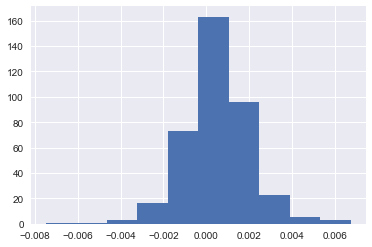

In [58]:
dataClean[dataClean['OpenRatioModi'] > 0.023]['nextpnl'].hist()

In [59]:
dataClean['pnl'].mean()

9.831805191008507e-05

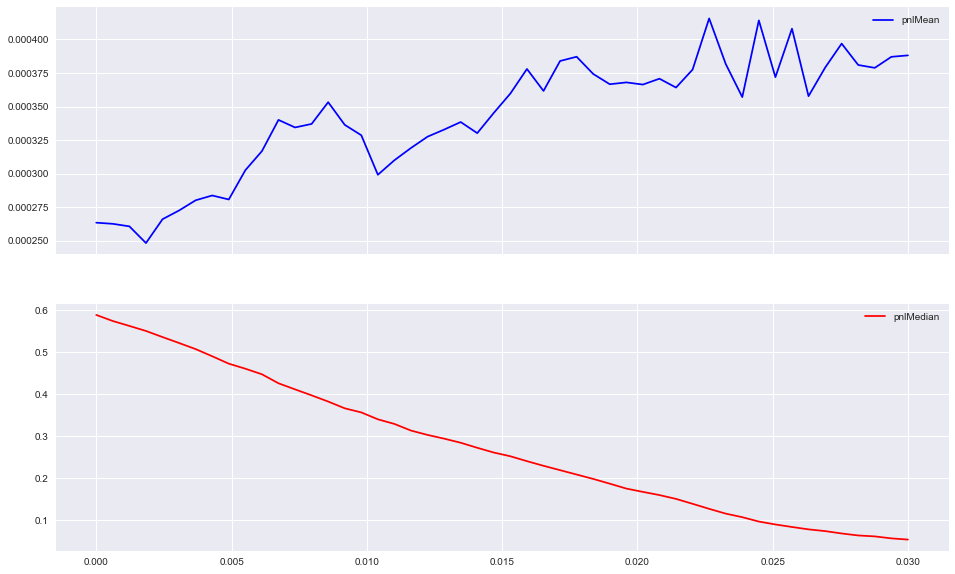

In [60]:
# check the monotonity of pnl filtered by openRatio indicator in bullish market
variation = []
bullpnlMeanList = []
bullpnlMedianList = []
x_axis = np.linspace(0,0.03,50)
for i in x_axis:
    variation.append(i)
    bullpnlMeanList.append(dataClean[dataClean['OpenRatioModi'] >= i]['pnl'].mean())
    bullpnlMedianList.append(dataClean[dataClean['OpenRatioModi'] >= i]['pnl'].shape[0] / dataClean.shape[0])
fig, (ax1,ax2) = plt.subplots(nrows=2,sharex=True,figsize=(16,10))
ax1.plot(x_axis,bullpnlMeanList,'blue',label='pnlMean')
ax2.plot(x_axis,bullpnlMedianList,'red',label='pnlMedian')
ax1.legend()
ax2.legend()

新指标做多阈值大概为0.02(0.85左右的分位数)，做空为0.024(0.8的分位数),也可取（0.85的分位数0.0275）

In [61]:
np.sqrt(np.array([1,2,3,4]))/np.sqrt(np.array([1,2,3,4])).sum()

array([ 0.16270045,  0.23009319,  0.28180545,  0.32540091])

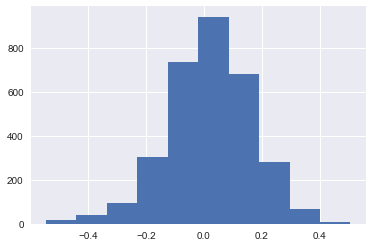

In [62]:
dataClean['OpenRatio'].hist()

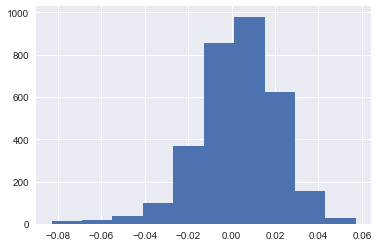

In [63]:
dataClean['OpenRatioModi'].hist()

In [64]:
a,b,c = 10000,3000,7000
print np.sqrt(a) / (np.sqrt(a)+np.sqrt(b)+np.sqrt(c))
print np.sqrt(b) / (np.sqrt(a)+np.sqrt(b)+np.sqrt(c))
print np.sqrt(c) / (np.sqrt(a)+np.sqrt(b)+np.sqrt(c))

0.419395782663
0.229712530687
0.350891686651


In [65]:
print 3/(1+2+3)
print 1/(1+2+3)
print 2/(1+2+3)

0.5
0.166666666667
0.333333333333


In [66]:
print np.log10(a) / (np.log10(a)+np.log10(b)+np.log10(c))
print np.log10(b) / (np.log10(a)+np.log10(b)+np.log10(c))
print np.log10(c) / (np.log10(a)+np.log10(b)+np.log10(c))

0.353287628147
0.307105980215
0.339606391638


In [67]:
print np.log(a) / (np.log(a)+np.log(b)+np.log(c))
print np.log(b) / (np.log(a)+np.log(b)+np.log(c))
print np.log(c) / (np.log(a)+np.log(b)+np.log(c))

0.353287628147
0.307105980215
0.339606391638


In [68]:
# modify data by customized method
dataIndice = data.loc[startTime:]
for index, row in dataIndice.iterrows():
    if (index.datetime.minute+1) % 5 ==0:
        if fiveBar:
            fiveBar = fiveBar
            fiveBar.high = max(fiveBar.high, row['High'])
            fiveBar.low = min(fiveBar.low, row['Low'])
            fiveBar.close = row['Close']
            fiveBar.open = row['Open']
            fiveBar.volume+= row['Volume']
            fiveBar.openInterest = row['OpenInterest']
            fiveBar.openRatio = row['OpenRatio']
            # your rule to clean data
            fiveBar = None
    else:
        if not fiveBar:
            fiveBar = BarData()
            fiveBar.high = row['High']
            fiveBar.low =  row['Low']
            fiveBar.open = row['Open']
            fiveBar.close = row['Close']
            fiveBar.volume= row['Volume']
            fiveBar.openInterest = row['OpenInterest']
            fiveBar.openRatio = row['OpenRatio']
            
            fiveBar.date = index.date
            fiveBar.time = index.time
            fiveBar.datetime = index.datetime
        else:
            fiveBar = fiveBar
            fiveBar.high = max(fiveBar.high,row['High'])
            fiveBar.low = min(fiveBar.low, row['Low'])
            fiveBar.close = row['Close']
            fiveBar.open = row['Open']
            fiveBar.volume+= row['Volume']
            fiveBar.openInterest = row['OpenInterest']
            fiveBar.openRatio = row['OpenRatio']

AttributeError: 'Timestamp' object has no attribute 'datetime'

In [69]:
c = data.loc[startTime:].groupby(pd.TimeGrouper(freq='5Min'))

In [70]:
nlarge = c['TotalVolume'].nlargest()

In [71]:
nlarge.iloc[:50]

2016-10-10 09:00:00  2016-10-10 09:00:00    152124
                     2016-10-10 09:03:00     58238
                     2016-10-10 09:01:00     56340
                     2016-10-10 09:02:00     46010
                     2016-10-10 09:04:00     27602
2016-10-10 09:05:00  2016-10-10 09:08:00     93250
                     2016-10-10 09:09:00     86728
                     2016-10-10 09:07:00     56208
                     2016-10-10 09:05:00     36690
                     2016-10-10 09:06:00     34316
2016-10-10 09:10:00  2016-10-10 09:10:00    126300
                     2016-10-10 09:11:00     67616
                     2016-10-10 09:12:00     39392
                     2016-10-10 09:14:00     27860
                     2016-10-10 09:13:00     27846
2016-10-10 09:15:00  2016-10-10 09:15:00     48790
                     2016-10-10 09:18:00     29964
                     2016-10-10 09:16:00     26416
                     2016-10-10 09:19:00     18350
                     2016-10-10

In [72]:
# Rescale openratio by the rank of Volume corresponding trading minute. e.g.Weighing the Open ratio by the order of total volume.
a = c['TotalVolume'].rank()/15 * data['OpenRatio']  
dataslice = data.loc[a.index]
dataslice['ModiOR'] = a
dataslice.groupby(pd.TimeGrouper(freq='5Min'))['OpenRatio'].mean().dropna().describe()

count    115342.000000
mean         -0.003659
std           0.141564
min          -0.962924
25%          -0.079623
50%           0.005921
75%           0.084264
max           0.770955
Name: OpenRatio, dtype: float64

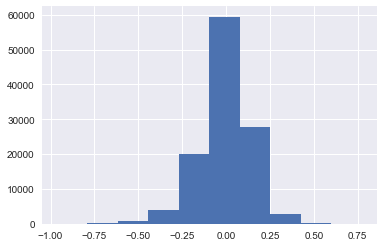

In [73]:
dataslice.groupby(pd.TimeGrouper(freq='5Min'))['OpenRatio'].mean().dropna().hist()

In [74]:
dataModi = dataslice.groupby(pd.TimeGrouper(freq='5Min'))['OpenRatio'].mean().dropna()
dataModi.quantile(0.85)

0.12726867627939592

In [75]:
def resample_data(data,period='5Min'):
    # 将一分钟线聚合为5分钟线
    databy5min = pd.DataFrame()
    groupgenerator = data.groupby(pd.TimeGrouper(freq=period))
    databy5min['Open'] = groupgenerator['Open'].first()
    databy5min['High'] = groupgenerator['High'].max()
    databy5min['Low'] = groupgenerator['Low'].min()
    databy5min['Close'] = groupgenerator['Close'].last()
    databy5min['TotalVolume'] = groupgenerator['TotalVolume'].sum()
    databy5min['OpenInterest'] = groupgenerator['OpenInterest'].last()
    databy5min.dropna(axis=0,inplace = True)
    return databy5min

In [76]:
dfResampled = resample_data(data)

In [77]:
dfResampled['OpenRatio'] = (dfResampled['OpenInterest'] - dfResampled['OpenInterest'].shift(1)) / dfResampled['TotalVolume']
dfResampled['WeightedOpenRatio'] = (dfResampled['OpenInterest'] - dfResampled['OpenInterest'].shift(1)) / np.sqrt(dfResampled['TotalVolume'])
dfResampled['pnl'] = dfResampled['Close'].pct_change()

In [78]:
sampleSurge= dfResampled.loc[startTimeSurge:endTimeSurge]
sampleSurge['nextpnl'] = sampleSurge['pnl'].shift(-1)

c:\python27\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [79]:
sampleSurge

,Open,High,Low,Close,TotalVolume,OpenInterest,OpenRatio,WeightedOpenRatio,pnl,nextpnl
2017-06-06 09:00:00,2905.0,2912.0,2901.0,2910.0,149516.0,5106840.0,-0.032558,-12.589449,0.003794,0.000344
2017-06-06 09:05:00,2910.0,2918.0,2910.0,2911.0,156324.0,5105254.0,-0.010146,-4.011348,0.000344,-0.001718
2017-06-06 09:10:00,2912.0,2912.0,2905.0,2906.0,82338.0,5102344.0,-0.035342,-10.141281,-0.001718,0.003097
2017-06-06 09:15:00,2906.0,2917.0,2906.0,2915.0,85270.0,5108550.0,0.072781,21.252677,0.003097,0.000343
2017-06-06 09:20:00,2916.0,2922.0,2912.0,2916.0,129160.0,5109646.0,0.008486,3.049626,0.000343,-0.000686
2017-06-06 09:25:00,2916.0,2917.0,2912.0,2914.0,45494.0,5109714.0,0.001495,0.318810,-0.000686,-0.002059
2017-06-06 09:30:00,2914.0,2914.0,2907.0,2908.0,67542.0,5107228.0,-0.036807,-9.565643,-0.002059,0.002407
2017-06-06 09:35:00,2909.0,2917.0,2908.0,2915.0,44616.0,5115958.0,0.195670,41.330335,0.002407,0.000343
2017-06-06 09:40:00,2915.0,2920.0,2915.0,2916.0,84156.0,5118780.0,0.033533,9.727796,0.000343,0.002743
2017-06-06 09:45:00,2916.0,2925.0,2916.0,2924.0,131376.0,5104672.0,-0.107386,-38.923101,0.002743,-0.001368


In [80]:
samplePlunge = dfResampled.loc[startTimePlunge:endTimePlunge]
samplePlunge['nextpnl'] = samplePlunge['pnl'].shift(-1)

c:\python27\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


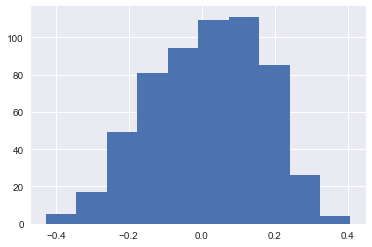

In [81]:
samplePlunge['OpenRatio'].hist()

In [82]:
sampleSurge['nextpnl'].describe()

count    3172.000000
mean        0.000099
std         0.002195
min        -0.014327
25%        -0.000899
50%         0.000000
75%         0.001187
max         0.043041
Name: nextpnl, dtype: float64

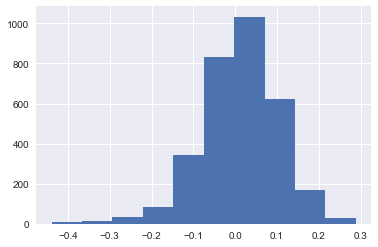

In [83]:
sampleSurge['OpenRatio'].hist()

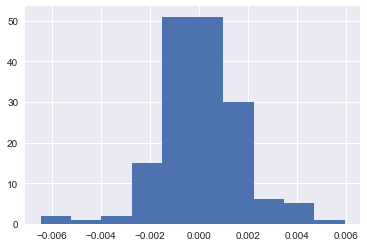

In [84]:
sampleSurge[sampleSurge['OpenRatio'] > .15]['nextpnl'].hist()

In [85]:
sampleSurge[sampleSurge['OpenRatio'] > 0.03]['nextpnl'].describe()

count    1353.000000
mean        0.000102
std         0.001910
min        -0.014327
25%        -0.000851
50%         0.000000
75%         0.001120
max         0.010653
Name: nextpnl, dtype: float64

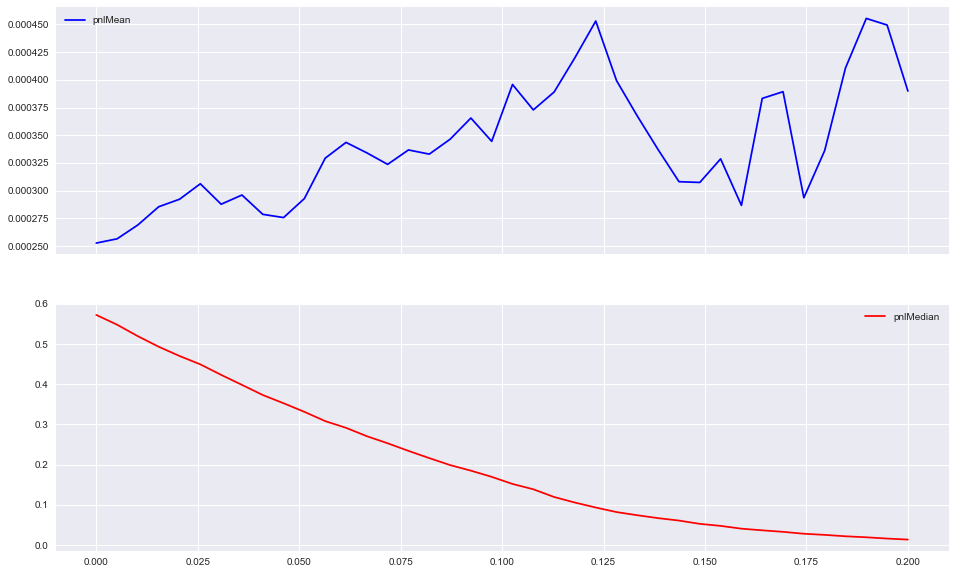

In [86]:
# check the monotonity of pnl filtered by openRatio indicator in bullish market
variation = []
bullpnlMeanList = []
bullpnlMedianList = []
for i in np.linspace(0,0.2,40):
    variation.append(i)
    bullpnlMeanList.append(sampleSurge[sampleSurge['OpenRatio'] >= i]['pnl'].mean())
    bullpnlMedianList.append(sampleSurge[sampleSurge['OpenRatio'] >= i].shape[0] / sampleSurge.shape[0])
fig, (ax1,ax2) = plt.subplots(nrows=2,sharex=True,figsize=(16,10))
ax1.plot(np.linspace(0,0.2,40),bullpnlMeanList,'blue',label='pnlMean')
ax2.plot(np.linspace(0,0.2,40),bullpnlMedianList,'red',label='pnlMedian')
ax1.legend()
ax2.legend()

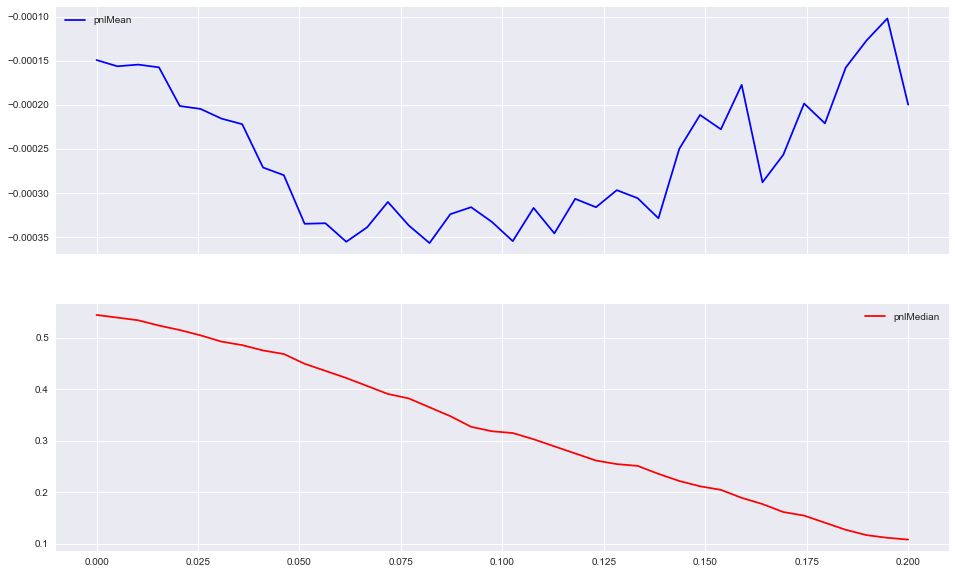

In [87]:
# check the monotonity of pnl filtered by openRatio indicator in bearrih market
variation = []
bearpnlMeanList = []
bearpnlMedianList = []
for i in np.linspace(0,0.2,40):
    variation.append(i)
    bearpnlMeanList.append(samplePlunge[samplePlunge['OpenRatio'] >= i]['nextpnl'].mean())
    bearpnlMedianList.append(samplePlunge[samplePlunge['OpenRatio'] >= i].shape[0] / samplePlunge.shape[0])
fig, (ax1,ax2) = plt.subplots(nrows=2,sharex=True,figsize=(16,10))
ax1.plot(np.linspace(0,0.2,40),bearpnlMeanList,'blue',label='pnlMean')
ax2.plot(np.linspace(0,0.2,40),bearpnlMedianList,'red',label='pnlMedian')
ax1.legend()
ax2.legend()

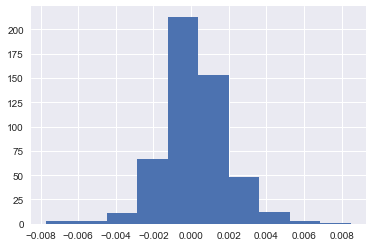

In [88]:
sampleSurge[sampleSurge['OpenRatio'] >= 0.1]['nextpnl'].hist()

In [89]:
pnlMedianList

NameError: name 'pnlMedianList' is not defined

In [ ]:
dfResampled['OpenRatio'].loc[startTime:].hist()

In [ ]:
dfResampled['WeightedOpenRatio'].quantile(0.996)

In [ ]:
dfResampled[dfResampled['OpenRatio'] > 0].mean()

In [ ]:
dfResampled['OpenRatio'].tail(500).plot()

In [ ]:
dfResampled['Close'].tail(30).plot()

In [ ]:
dfResampled[['pnl','OpenRatio']].tail(50)

In [ ]:
len(dfResampled[dfResampled['OpenRatio'] < 0.15]) / len(dfResampled)

In [ ]:
len(dfResampled[dfResampled['OpenRatio'] < 0]) / len(dfResampled)

In [ ]:
np.sqrt(0.33*225/5)

In [ ]:
datatrain = dfResampled.loc[startTrainTime:endTimeTrain]

In [ ]:
startTime

In [ ]:
datatrain['EMAOpenRatio'] = talib.EMA(datatrain['OpenRatio'].values, timeperiod=4)

datatrain['EMAOpenRatio'].describe()

In [ ]:
datatrain['OpenRatio'].describe()

In [ ]:
datatrain['EMAOpenRatio'].quantile(0.92)

In [ ]:
datatrain['OpenRatio'].quantile(0.9)

In [ ]:
# show size distribution(quantile plot)
fig = plt.figure(figsize=(16,10))
# Add a subplot
ax = fig.add_subplot(111)
datatrain['EMAOpenRatio'].hist(alpha =0.8)
datatrain['OpenRatio'].hist(alpha = 0.3)
ax.set_title(ax.get_title(),alpha=0.7, fontsize=25)

In [ ]:
datatrain['EMAOpenRatio'].hist()
datatrain['OpenRatio'].hist(alpha = 0.3)

In [ ]:
datatrain['OpenRatio'].describe()

In [ ]:
dfResampled['Close'].plot(figsize=(18,12))

In [ ]:
shapeNum = 20

In [ ]:
svdindicator = getSVD(datatrain['Close'].values[-shapeNum:], shapeNum, svdShort)

In [ ]:
svdindicator1 = getSVD(datatrain['Close'].values[-shapeNum:], shapeNum, svdLong)
svdindicator1

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True,figsize=(16,10))
ax1.plot(datatrain.index[-shapeNum:],datatrain['Close'].values[-shapeNum:],'blue',label='Close')
ax2.plot(datatrain.index[-shapeNum:],svdindicator,'green',)
ax2.plot(datatrain.index[-shapeNum:],svdindicator1,'black')
#ax1.title('SVD')

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True,figsize=(22,16))
ax1.plot(datatrain['Close'].values[-shapeNum:],'blue',label='Close')
ax2.plot(svdindicator,'red',label='svd-'+str(svdShort))
ax2.plot(svdindicator1,'yellow',label='svd-'+str(svdLong))
#ax1.title('SVD')
ax1.legend()
ax2.legend()

In [ ]:
datatrain['Close'].plot(figsize=(18,12))

In [ ]:
#kvol.median()

In [ ]:
kvol = (datatrain['Close'] - datatrain['Close'].shift(1)).rolling(min_periods=60,window=60,center=False).std()

In [ ]:
kvol.iloc[-100:].plot(figsize=(18,12))
((7*datatrain['Close']/datatrain['Close'].iloc[0]).iloc[-100:]).plot(sharex=True)

In [ ]:
datatrain['Close'].iloc[-500:].plot(figsize=(18,12))

In [ ]:
datatrain['Impact'] = (datatrain['Close'] - datatrain['Open']) / datatrain['TotalVolume']   

In [ ]:
datatrain['Impact'].iloc[-55:].plot(figsize=(18,12))

In [ ]:
datatrain['TotalVolume'].iloc[-55:].mean()

In [ ]:
datatrain[datatrain['Impact']>0]

In [ ]:
filtered = datatrain[(datatrain['TotalVolume']<datatrain['TotalVolume'].quantile(0.2)) & (datatrain['Impact']>((datatrain[datatrain['Impact']>0]['Impact']).quantile(0.7)))]

In [ ]:
filtered

In [ ]:
datatrain.iloc[:2]

In [ ]:
filtered['Close'].plot(figsize=(18,10))

In [ ]:
trackBackPeriod = 50
code = 'rb000' 
initialNum = 100

In [ ]:
futurebuyList = []
for i in range(initialNum,len(datatrain)-1):
    svdshortArray = getSVD(datatrain['Close'].values[i+1-trackBackPeriod:i+1], trackBackPeriod, svdShort)
    svdlongArray = getSVD(datatrain['Close'].values[i+1-trackBackPeriod:i+1], trackBackPeriod, svdLong)
    if svdshortArray[-2] < svdlongArray[-2] and svdshortArray[-1] > svdlongArray[-1]:
        dfslice = datatrain.iloc[i+1]
        amount = 1
        price = dfslice['Open']
        cost = price * amount
        direction = 1
        futurebuyList.append([dfslice.name,code,price,amount,cost,direction])

In [ ]:
futurebuyList